<a href="https://colab.research.google.com/github/dribnet/pixray_notebooks/blob/master/pixray_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


# Add a gpu check
# (this can get better over time)
from google.colab import output
import sys

nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, THIS IS PROBABLY NOT ENOUGH <--"
  print(warning_string)
  output.eval_js('alert("Warning - low GPU (see message)")')
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

from IPython.utils import io
with io.capture_output() as captured:
  # this patch applied to fix torchtext dependency 11 Nov 2021
  !sudo apt-get install gcc-7 g++-7 -y
  !sudo ln -s /usr/bin/gcc-7 /usr/bin/gcc
  !sudo ln -s /usr/bin/g++-7 /usr/bin/g++
  !sudo ln -s /usr/bin/gcc-7 /usr/bin/cc
  !sudo ln -s /usr/bin/g++-7 /usr/bin/c++

  !git clone https://github.com/openai/CLIP
  # !pip install taming-transformers
  !git clone https://github.com/CompVis/taming-transformers.git
  !rm -Rf pixray
  !git clone https://github.com/dribnet/pixray
  !pip install ftfy regex tqdm omegaconf pytorch-lightning
  !pip install kornia==0.6.1
  !pip install imageio-ffmpeg
  !pip install einops
  !pip install torch-optimizer
  !pip install easydict
  !pip install braceexpand
  !pip install git+https://github.com/pvigier/perlin-numpy

  # ClipDraw deps
  !pip install svgwrite
  !pip install svgpathtools
  !pip install cssutils
  !pip install numba
  !pip install torch-tools
  !pip install visdom

  !git clone https://github.com/BachiLi/diffvg
  %cd diffvg
  # !ls
  !git submodule update --init --recursive
  sys.path.append("diffvg/build/lib.linux-x86_64-cpython-310")

  !python setup.py install






  %cd ..

output.clear()
sys.path.append("pixray")

result_msg = "setup complete"
import IPython
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  result_msg = "Please choose Runtime -> Restart Runtime from the menu, and then run Setup again"

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

In [2]:
%%writefile taming-transformers/taming/data/utils.py

import collections
import os
import tarfile
import urllib
import zipfile
from pathlib import Path

import numpy as np
import torch
from taming.data.helper_types import Annotation
string_classes = str
from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format
from tqdm import tqdm


def unpack(path):
    if path.endswith("tar.gz"):
        with tarfile.open(path, "r:gz") as tar:
            tar.extractall(path=os.path.split(path)[0])
    elif path.endswith("tar"):
        with tarfile.open(path, "r:") as tar:
            tar.extractall(path=os.path.split(path)[0])
    elif path.endswith("zip"):
        with zipfile.ZipFile(path, "r") as f:
            f.extractall(path=os.path.split(path)[0])
    else:
        raise NotImplementedError(
            "Unknown file extension: {}".format(os.path.splitext(path)[1])
        )


def reporthook(bar):
    """tqdm progress bar for downloads."""

    def hook(b=1, bsize=1, tsize=None):
        if tsize is not None:
            bar.total = tsize
        bar.update(b * bsize - bar.n)

    return hook


def get_root(name):
    base = "data/"
    root = os.path.join(base, name)
    os.makedirs(root, exist_ok=True)
    return root


def is_prepared(root):
    return Path(root).joinpath(".ready").exists()


def mark_prepared(root):
    Path(root).joinpath(".ready").touch()


def prompt_download(file_, source, target_dir, content_dir=None):
    targetpath = os.path.join(target_dir, file_)
    while not os.path.exists(targetpath):
        if content_dir is not None and os.path.exists(
            os.path.join(target_dir, content_dir)
        ):
            break
        print(
            "Please download '{}' from '{}' to '{}'.".format(file_, source, targetpath)
        )
        if content_dir is not None:
            print(
                "Or place its content into '{}'.".format(
                    os.path.join(target_dir, content_dir)
                )
            )
        input("Press Enter when done...")
    return targetpath


def download_url(file_, url, target_dir):
    targetpath = os.path.join(target_dir, file_)
    os.makedirs(target_dir, exist_ok=True)
    with tqdm(
        unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=file_
    ) as bar:
        urllib.request.urlretrieve(url, targetpath, reporthook=reporthook(bar))
    return targetpath


def download_urls(urls, target_dir):
    paths = dict()
    for fname, url in urls.items():
        outpath = download_url(fname, url, target_dir)
        paths[fname] = outpath
    return paths


def quadratic_crop(x, bbox, alpha=1.0):
    """bbox is xmin, ymin, xmax, ymax"""
    im_h, im_w = x.shape[:2]
    bbox = np.array(bbox, dtype=np.float32)
    bbox = np.clip(bbox, 0, max(im_h, im_w))
    center = 0.5 * (bbox[0] + bbox[2]), 0.5 * (bbox[1] + bbox[3])
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    l = int(alpha * max(w, h))
    l = max(l, 2)

    required_padding = -1 * min(
        center[0] - l, center[1] - l, im_w - (center[0] + l), im_h - (center[1] + l)
    )
    required_padding = int(np.ceil(required_padding))
    if required_padding > 0:
        padding = [
            [required_padding, required_padding],
            [required_padding, required_padding],
        ]
        padding += [[0, 0]] * (len(x.shape) - 2)
        x = np.pad(x, padding, "reflect")
        center = center[0] + required_padding, center[1] + required_padding
    xmin = int(center[0] - l / 2)
    ymin = int(center[1] - l / 2)
    return np.array(x[ymin : ymin + l, xmin : xmin + l, ...])


def custom_collate(batch):
    r"""source: pytorch 1.9.0, only one modification to original code """

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        out = None
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        if elem_type.__name__ == 'ndarray' or elem_type.__name__ == 'memmap':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(default_collate_err_msg_format.format(elem.dtype))

            return custom_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, collections.abc.Mapping):
        return {key: custom_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(custom_collate(samples) for samples in zip(*batch)))
    if isinstance(elem, collections.abc.Sequence) and isinstance(elem[0], Annotation):  # added
        return batch  # added
    elif isinstance(elem, collections.abc.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError('each element in list of batch should be of equal size')
        transposed = zip(*batch)
        return [custom_collate(samples) for samples in transposed]

    raise TypeError(default_collate_err_msg_format.format(elem_type))


Overwriting taming-transformers/taming/data/utils.py


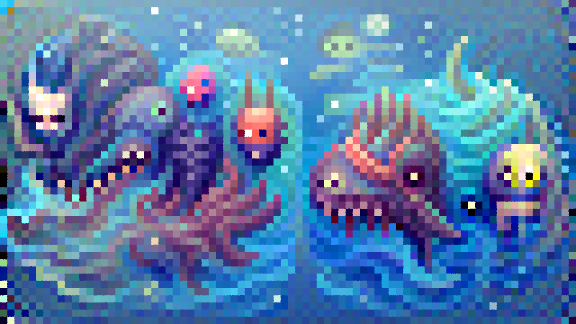

iter: 300, finished (-8=>2.362)


True

In [3]:
# import sys
# sys.path.append("pixray")
# Simple setup
import pixray

prompts = "deep ocean monsters #pixelart"
drawer = "pixel"

# these are good settings for pixeldraw
pixray.reset_settings()
pixray.add_settings(prompts=prompts)
pixray.add_settings(quality="better")
pixray.add_settings(drawer=drawer)
pixray.add_settings(custom_loss="saturation:0.5,smoothness:2")
pixray.add_settings(smoothness_type="log")
pixray.add_settings(display_clear=True)
settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
